In [1]:
#  pip install -r requirements.txt

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
import IPython.display as display


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout

from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split

import cv2
import os
import xml.etree.cElementTree as et

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D

In [3]:
""" Unzipping data set to a local director  """

from zipfile import ZipFile

with ZipFile("F:\\Coding\\cv_challenge\\archive.zip", 'r') as Dataset:
    Dataset.extractall()

### Task 1 : Convert image data into TFRecordDataset format

In [4]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [27]:
data_folder = ('F:\\Coding\\cv_challenge\\NEU-DET')
train_folder_path = os.path.join(data_folder, "train", )
valid_folder_path = os.path.join(data_folder, "validation", )

def create_img_list(folder_path):
    image_list = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                image_list.append(image_path)

    return image_list

train_img_list = create_img_list(train_folder_path)
valid_img_list = create_img_list(valid_folder_path)
# print(train_img_list)


train_anno_path = os.path.join(data_folder,"train", "annotations")
train_anno_files_list = os.listdir(train_anno_path)
valid_anno_path = os.path.join(data_folder,"validation", "annotations")
valid_anno_files_list = os.listdir(valid_anno_path)
print(train_anno_path)
print(train_anno_files_list)
print(valid_anno_path)
print(valid_anno_files_list)

F:\Coding\cv_challenge\NEU-DET\train\annotations
['crazing_1.xml', 'crazing_10.xml', 'crazing_100.xml', 'crazing_101.xml', 'crazing_102.xml', 'crazing_103.xml', 'crazing_104.xml', 'crazing_105.xml', 'crazing_106.xml', 'crazing_107.xml', 'crazing_108.xml', 'crazing_109.xml', 'crazing_11.xml', 'crazing_110.xml', 'crazing_111.xml', 'crazing_112.xml', 'crazing_113.xml', 'crazing_114.xml', 'crazing_115.xml', 'crazing_116.xml', 'crazing_117.xml', 'crazing_118.xml', 'crazing_119.xml', 'crazing_12.xml', 'crazing_120.xml', 'crazing_121.xml', 'crazing_122.xml', 'crazing_123.xml', 'crazing_124.xml', 'crazing_125.xml', 'crazing_126.xml', 'crazing_127.xml', 'crazing_128.xml', 'crazing_129.xml', 'crazing_13.xml', 'crazing_130.xml', 'crazing_131.xml', 'crazing_132.xml', 'crazing_133.xml', 'crazing_134.xml', 'crazing_135.xml', 'crazing_136.xml', 'crazing_137.xml', 'crazing_138.xml', 'crazing_139.xml', 'crazing_14.xml', 'crazing_140.xml', 'crazing_141.xml', 'crazing_142.xml', 'crazing_143.xml', 'crazin

In [6]:
""" Extracting Lables from XML files """

def parseXML(xmlfile):
    # create element tree object 
    tree = et.parse(xmlfile)  
    # get root element 
    root = tree.getroot()

    data = {}
    data['filename'] = root.find('filename').text

    size = root.find('size')
    data['size'] = {
        'width': int(size.find('width').text),
        'height': int(size.find('height').text),
        'depth': int(size.find('depth').text)
    }
    
    obj = root.find('object')
    data['object'] = {
        'name': obj.find('name').text,
        'pose': obj.find('pose').text,
        'truncated': int(obj.find('truncated').text),
        'difficult': int(obj.find('difficult').text),
        'bndbox': {
            'xmin': int(obj.find('bndbox/xmin').text),
            'ymin': int(obj.find('bndbox/ymin').text),
            'xmax': int(obj.find('bndbox/xmax').text),
            'ymax': int(obj.find('bndbox/ymax').text)
        }
    }
    # objects = []
    # for obj in root.findall('object'):
    #     obj_data = {
    #         'name': obj.find('name').text,
    #         'pose': obj.find('pose').text,
    #         'truncated': int(obj.find('truncated').text),
    #         'difficult': int(obj.find('difficult').text),
    #         'bndbox': {
    #             'xmin': int(obj.find('bndbox/xmin').text),
    #             'ymin': int(obj.find('bndbox/ymin').text),
    #             'xmax': int(obj.find('bndbox/xmax').text),
    #             'ymax': int(obj.find('bndbox/ymax').text)
    #         }
    #     }
    #     objects.append(obj_data)

    # data['objects'] = objects

    return data

In [7]:
"""
Get distinct class labels from xml files
Returns a list of distinct labels
"""

labels = []
for anno in train_anno_files_list:
    attr = parseXML(train_anno_path +"\\"+anno)
    label = attr["object"]["name"]
    if label not in labels:
        labels.append(label)
print(labels)

"""
Assigning distinct values to each distinct label
"""
image_labels = {name: index for index, name in enumerate(labels)}
print(image_labels)


['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
{'crazing': 0, 'inclusion': 1, 'patches': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}


In [8]:
def get_image_example(image_string, width, height, filename, xmin, xmax, ymin, ymax, label, label_text):
  # print('w & h',width, height)
  feature = {
        "image/width": _int64_feature(width),
        "image/height": _int64_feature(height),
        "image/filename":_bytes_feature(bytes(filename, 'utf-8')),
        # 'image/source_id': root.find("source").text,
        "image/encodedrawdata": _bytes_feature(image_string),
        "image/format": _bytes_feature(bytes(filename.split(".")[-1], 'utf-8')),  # Assuming filename contains format
        "image/object/bbox/xmin": _float_feature(xmin),
        "image/object/bbox/xmax": _float_feature(xmax),
        "image/object/bbox/ymin": _float_feature(ymin),
        "image/object/bbox/ymax": _float_feature(ymax),
        "image/object/class/text": _bytes_feature(bytes(label_text, 'utf-8')),
        "image/object/class/label": _int64_feature(label),
        "image/object/class/single": _int64_feature(label),  # Assuming single class per object
        "image/object/difficult": _int64_feature(0),  # Difficult is 0
        "image/object/truncated": _int64_feature(0),  # Truncated is 0
        "image/object/view": _bytes_feature(bytes("Unspecified", 'utf-8'))  # Assuming view is Unspecified for simplicity
    }

  return tf.train.Example(features=tf.train.Features(feature=feature))

  """
  Followed the article of Reading-Writing TFRecord for Images
  https://www.tensorflow.org/tutorials/load_data/tfrecord
  """

In [9]:
# for img in train_img_list:
#   img_name_ext = img.split("\\")[-1]
#   img_name = img_name_ext.split('.')[0]


#   for anno in train_anno_files_list:
#     anno_name = anno.split(".")[0]
    
#     if img_name == anno_name:
#       attr = parseXML(train_anno_path +"\\"+anno)

#       image_string = open(img, 'rb').read()

#       filename = attr["filename"]
#       # print(filename)
#       # print(filename.split('.')[1])
#       width = attr["size"]["width"]
#       height = attr["size"]["height"]

#       xmin = attr["object"]["bndbox"]["xmin"]
#       ymin = attr["object"]["bndbox"]["ymin"]
#       xmax = attr["object"]["bndbox"]["xmax"]
#       ymax = attr["object"]["bndbox"]["ymax"]

#       # for obj in attr["object"]:
#       #   print(obj)
#       #   xmin = obj["bndbox"]["xmin"]
#       #   ymin = obj["bndbox"]["ymin"]
#       #   xmax = obj["bndbox"]["xmax"]
#       #   ymax = obj["bndbox"]["ymax"]

#       label_text = attr["object"]["name"]
#       label = image_labels.get(label_text, -1)  # Get label index or -1 if not found

#       # for line in str(get_image_example(image_string, width, height, filename, xmin, xmax, ymin, ymax, label, label_text)).split('\n')[:15]:
#       #   print(line)
#       # print('...')

In [28]:
def convert(image_paths,anno_list,anno_path, out_path):
    # print('img :',image_paths)
    # print('Op: ', out_path)
    for img in image_paths:

        img_name_ext = img.split("\\")[-1]
        img_name = img_name_ext.split('.')[0]

        for anno in anno_list:
            anno_name = anno.split(".")[0]
    

            if img_name == anno_name:
                attr = parseXML(anno_path +"\\"+anno)

                image_string = open(img, 'rb').read()

                filename = attr["filename"]
                # print(filename)
                # print(filename.split('.')[1])
                width = attr["size"]["width"]
                height = attr["size"]["height"]

                xmin = attr["object"]["bndbox"]["xmin"]
                ymin = attr["object"]["bndbox"]["ymin"]
                xmax = attr["object"]["bndbox"]["xmax"]
                ymax = attr["object"]["bndbox"]["ymax"]

                # for obj in attr["object"]:
                #   print(obj)
                #   xmin = obj["bndbox"]["xmin"]
                #   ymin = obj["bndbox"]["ymin"]
                #   xmax = obj["bndbox"]["xmax"]
                #   ymax = obj["bndbox"]["ymax"]

                label_text = attr["object"]["name"]
                label = image_labels.get(label_text, -1)  # Get label index or -1 if not found

                image_string  = open((img), 'rb').read()
                # print('argumets \n', width, height, filename, xmin, xmax, ymin, ymax, label, label_text)
                tf_example = get_image_example(image_string, width, height, filename, xmin, xmax, ymin, ymax, label, label_text)

                file_name_ext = os.path.basename(img)
                file_name = os.path.splitext(file_name_ext)[0]
                output_filename = os.path.join(out_path, f'{file_name}.tfrecord')
                with tf.io.TFRecordWriter(output_filename) as writer:
                    writer.write(tf_example.SerializeToString())

In [29]:
convert(train_img_list,train_anno_files_list ,train_anno_path , 'F:\\Coding\\cv_challenge\\TF_Records\\Train')
convert(valid_img_list,valid_anno_files_list, valid_anno_path ,'F:\\Coding\\cv_challenge\\TF_Records\\Test')

In [42]:
tfr_train = "F:\Coding\cv_challenge\TF_Records\\train\scratches_6.tfrecord"
raw_image_dataset = tf.data.TFRecordDataset(filenames = [tfr_train])
raw_image_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [43]:
image_feature_description  = {
      "image/width": tf.io.FixedLenFeature([], tf.int64),
      "image/height": tf.io.FixedLenFeature([], tf.int64),
      'image/filename': tf.io.FixedLenFeature([], tf.string),
      # 'image/source_id': tf.io.FixedLenFeature([], tf.string),
      'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
      'image/format': tf.io.FixedLenFeature([], tf.string),
      'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
      'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
      'image/object/class/text': tf.io.VarLenFeature(tf.string),
      'image/object/class/label': tf.io.VarLenFeature(tf.int64),
      'image/object/class/single': tf.io.FixedLenFeature([], tf.int64),
      'image/object/difficult': tf.io.VarLenFeature(tf.int64),
      'image/object/truncated': tf.io.VarLenFeature(tf.int64),
      'image/object/view': tf.io.VarLenFeature(tf.string)
  }

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description )

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<_MapDataset element_spec={'image/object/bbox/xmax': SparseTensorSpec(TensorShape([None]), tf.float32), 'image/object/bbox/xmin': SparseTensorSpec(TensorShape([None]), tf.float32), 'image/object/bbox/ymax': SparseTensorSpec(TensorShape([None]), tf.float32), 'image/object/bbox/ymin': SparseTensorSpec(TensorShape([None]), tf.float32), 'image/object/class/label': SparseTensorSpec(TensorShape([None]), tf.int64), 'image/object/class/text': SparseTensorSpec(TensorShape([None]), tf.string), 'image/object/difficult': SparseTensorSpec(TensorShape([None]), tf.int64), 'image/object/truncated': SparseTensorSpec(TensorShape([None]), tf.int64), 'image/object/view': SparseTensorSpec(TensorShape([None]), tf.string), 'image/encodedrawdata': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/format': TensorSpec(shape=(), dtype=tf.string, name=None), 'image/height': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image/object/cla

tf.Tensor(b'scratches_6.jpg', shape=(), dtype=string)


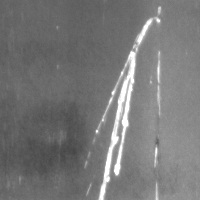

In [44]:
for image_features in parsed_image_dataset:
    # print(image_features['image/encodedrawdata'])
    image_raw = image_features['image/encodedrawdata'].numpy()
    print(image_features['image/filename'])
    display.display(display.Image(data=image_raw))

### Task 2 - Classification